# Get the page coordinates of a digitised newspaper article from Trove

In [1]:
from io import BytesIO

import requests
from bs4 import BeautifulSoup
from IPython.display import Image as DisplayImage
from IPython.display import display
from PIL import Image, ImageDraw

In [2]:
def get_box(zones):
    """
    Loop through all the zones to find the outer limits of each boundary.
    Return a bounding box around the article.
    """
    left = 10000
    right = 0
    top = 10000
    bottom = 0
    page_id = zones[0]["data-page-id"]
    for zone in zones:
        if int(zone["data-y"]) < top:
            top = int(zone["data-y"])
        if int(zone["data-x"]) < left:
            left = int(zone["data-x"])
        if (int(zone["data-x"]) + int(zone["data-w"])) > right:
            right = int(zone["data-x"]) + int(zone["data-w"])
        if (int(zone["data-y"]) + int(zone["data-h"])) > bottom:
            bottom = int(zone["data-y"]) + int(zone["data-h"])
    return {
        "page_id": page_id,
        "left": left,
        "top": top,
        "right": right,
        "bottom": bottom,
    }


def get_article_boxes(article_url):
    """
    Positional information about the article is attached to each block of the OCR output in data attributes.
    This function loads the HTML version of the article and scrapes the x, y, and width values for each block of text
    to determine the coordinates of a box around the article.
    """
    boxes = []
    # Get the article page
    response = requests.get(article_url)
    # Load in BS4
    soup = BeautifulSoup(response.text, "lxml")
    # Lines of OCR are in divs with the class 'zone'
    # 'onPage' limits to those on the current page
    zones = soup.select("div.zone.onPage")
    boxes.append(get_box(zones))
    off_page_zones = soup.select("div.zone.offPage")
    if off_page_zones:
        current_page = off_page_zones[0]["data-page-id"]
        zones = []
        for zone in off_page_zones:
            if zone["data-page-id"] == current_page:
                zones.append(zone)
            else:
                boxes.append(get_box(zones))
                zones = [zone]
                current_page = zone["data-page-id"]
        boxes.append(get_box(zones))
    return boxes


def display_boxes(boxes):
    for box in boxes:
        # Construct the url we need to download the page image
        page_url = (
            "https://trove.nla.gov.au/ndp/imageservice/nla.news-page{}/level{}".format(
                box["page_id"], 7
            )
        )
        # Download the page image
        response = requests.get(page_url)
        # Open download as an image for editing
        img = Image.open(BytesIO(response.content))
        img = img.convert(mode="RGB")
        draw = ImageDraw.Draw(img)
        # Draw a rectangle on the image
        draw.rectangle(
            [(box["left"], box["top"]), (box["right"], box["bottom"])],
            outline=(0, 255, 0),
            width=20,
        )
        buffer = BytesIO()
        img.save(buffer, format="JPEG")
        display(DisplayImage(data=buffer.getvalue(), width=400))

In [3]:
boxes = get_article_boxes(
    "https://trove.nla.gov.au/newspaper/article/258166628?searchTerm=wragge"
)
print(boxes)

[{'page_id': '28714846', 'left': 67, 'top': 5375, 'right': 769, 'bottom': 5980}]


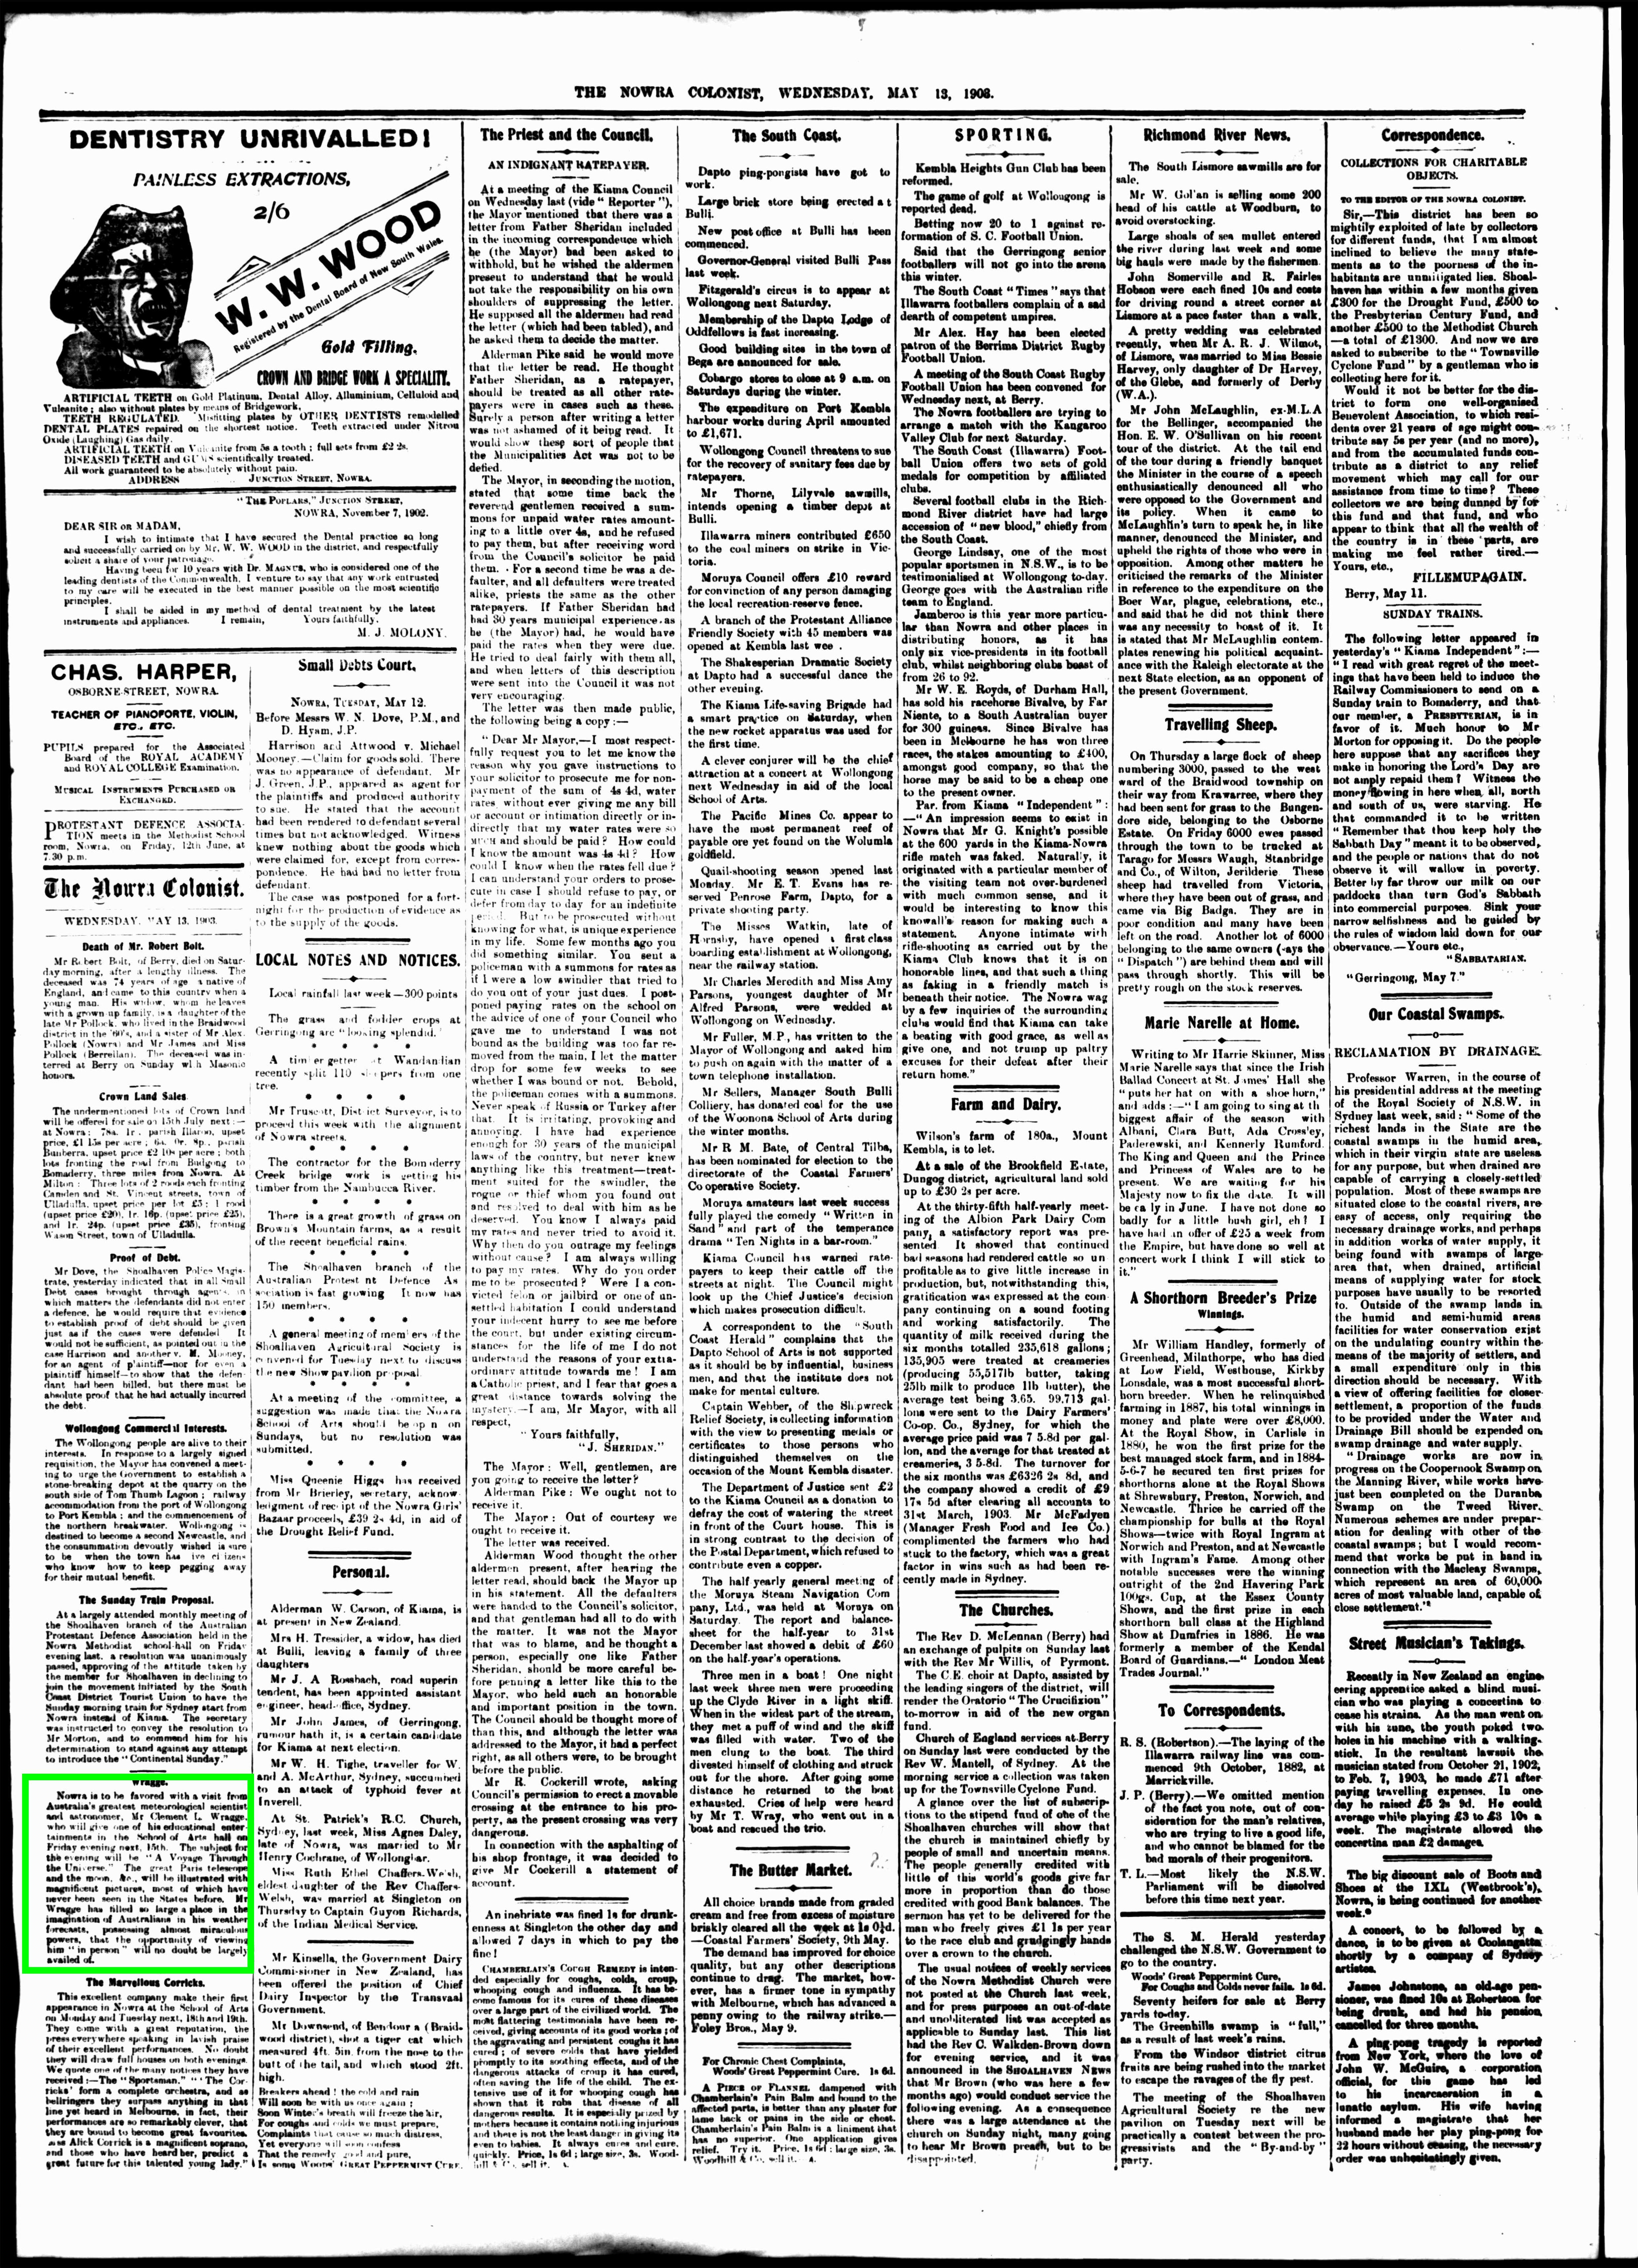

In [4]:
display_boxes(boxes)

## What can I do with this?

In the GLAM Workbench there's a notebook (and app) to save an article as an image using the code above. But what about building something like this into a pipeline to assemble a dataset of images? Perhaps illustrated advertisements by decade, or by product type, of from the *Australian Women's Weekly*? A collection of weather maps?

----

Created by [Tim Sherratt](https://timsherratt.org/) for the [GLAM Workbench](https://glam-workbench.github.io/).  
Support this project by becoming a [GitHub sponsor](https://github.com/sponsors/wragge?o=esb).

